In [1]:
!pip install scikit-learn==1.3.2

In [2]:
!pip install lazypredict

In [3]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb
from joblib import dump
import itertools
import matplotlib.pyplot as plt
import numpy as np
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
rice_df = pd.read_excel('/content/rice_w2vec_3mer_dataset.xlsx')
rice_df = rice_df.drop(['circName','tissue','chr','start','end','strand','start_anno', 'circID',	'gene', 'isoform', 'width', 'detection_score', 'stress_detection_score', 'end_anno', 'antisense', 'algorithm', 'seq', 'exonSeq', 'predAA', 'miRNA','superCircRNARegion'], axis=1)

In [5]:
maize_df = pd.read_excel('maize_w2vec_3mer_dataset.xlsx')
maize_df = maize_df.drop(['circName','tissue','chr','start','end','strand','start_anno', 'circID',	'gene', 'isoform', 'width', 'detection_score', 'stress_detection_score', 'end_anno', 'antisense', 'algorithm', 'seq', 'exonSeq', 'predAA', 'miRNA','superCircRNARegion'], axis=1)

In [6]:
df = rice_df._append(maize_df, ignore_index = True)

In [7]:
df_drought = df.query('stress == "-" or stress == "drought"').replace('-', 0).replace('drought', 1)

### Training and Testing Models

In [8]:
# Define X and y (target) variables
X = df_drought.drop(['stress'], axis=1)
y = df_drought['stress']

In [9]:
X.head(2)

,wc_3mer_1,wc_3mer_2,wc_3mer_3,wc_3mer_4,wc_3mer_5,wc_3mer_6,wc_3mer_7,wc_3mer_8,wc_3mer_9,wc_3mer_10,...,wc_3mer_55,wc_3mer_56,wc_3mer_57,wc_3mer_58,wc_3mer_59,wc_3mer_60,wc_3mer_61,wc_3mer_62,wc_3mer_63,wc_3mer_64
0,-8.66,-17.17,-20.12,10.61,-0.19,1.57,3.90,7.62,-2.83,13.90,...,-21.98,-12.45,-8.38,-9.52,28.57,7.25,-18.07,-6.67,-3.78,1.30
1,-4.62,-42.06,-73.49,-51.22,83.97,-47.22,-20.22,29.19,-17.14,37.22,...,24.44,-68.49,20.16,14.18,81.44,-4.52,21.87,-10.53,-39.17,63.34


In [10]:
y.value_counts()

,count
stress,
0,70996
1,12030


In [11]:
ros = RandomUnderSampler(sampling_strategy=0.7)

X_res, y_res = ros.fit_resample(X, y)

In [12]:
y_res.value_counts()

,count
stress,
0,17185
1,12030


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=92)

In [14]:
model_lgb = lgb.LGBMClassifier(random_state=92)
model_lgb.fit(X_train, y_train)

y_pred_lgb = model_lgb.predict(X_test)
report = classification_report(y_test, y_pred_lgb)
print(report)

[LightGBM] [Info] Number of positive: 9664, number of negative: 13708
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 23372, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.413486 -> initscore=-0.349572
[LightGBM] [Info] Start training from score -0.349572
              precision    recall  f1-score   support

           0       0.92      0.74      0.82      3477
           1       0.70      0.90      0.79      2366

    accuracy                           0.81      5843
   macro avg       0.81      0.82      0.80      5843
weighted avg       0.83      0.81      0.81      5843



In [15]:
from sklearn.ensemble import RandomForestClassifier

modelrf = RandomForestClassifier(random_state=92)
modelrf.fit(X_train, y_train)

y_pred_rf = modelrf.predict(X_test)
report = classification_report(y_test, y_pred_rf)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.75      0.82      3477
           1       0.70      0.87      0.78      2366

    accuracy                           0.80      5843
   macro avg       0.80      0.81      0.80      5843
weighted avg       0.82      0.80      0.80      5843



In [26]:
from sklearn.ensemble import ExtraTreesClassifier

modelext = ExtraTreesClassifier(random_state=92)
modelext.fit(X_train, y_train)

y_pred_ext = modelext.predict(X_test)
report = classification_report(y_test, y_pred_ext)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.75      0.82      3477
           1       0.70      0.88      0.78      2366

    accuracy                           0.80      5843
   macro avg       0.80      0.81      0.80      5843
weighted avg       0.82      0.80      0.80      5843



In [17]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)
report = classification_report(y_test, y_pred_dummy)
print(report)

              precision    recall  f1-score   support

           0       0.60      1.00      0.75      3477
           1       0.00      0.00      0.00      2366

    accuracy                           0.60      5843
   macro avg       0.30      0.50      0.37      5843
weighted avg       0.35      0.60      0.44      5843



In [18]:
dump(model_lgb, 'lgb_model_drought_3mer.joblib')
print('LGB - Cold Model created.')

LGB - Cold Model created.


In [19]:
dump(modelrf, 'rf_model_drought_3mer.joblib')
print('RF - Cold Model created.')

RF - Cold Model created.


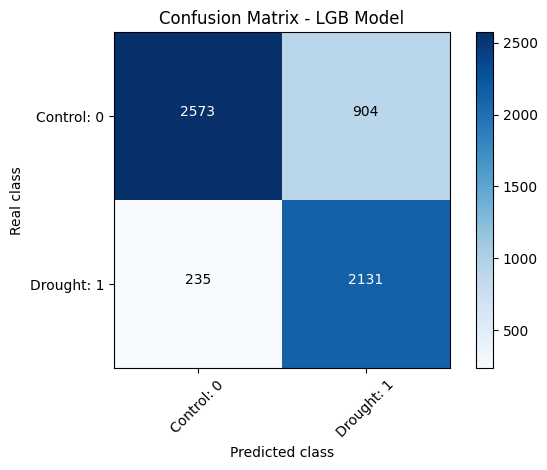

In [20]:
cnf_matrix = confusion_matrix(y_test, y_pred_lgb)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix - LGB Model',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #plt.ylim(0.5, 0.5)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(1.5, -0.5)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Real class')
    plt.xlabel('Predicted class')
    plt.tight_layout()

plot_confusion_matrix(cnf_matrix, classes=['Control: 0', 'Drought: 1'])

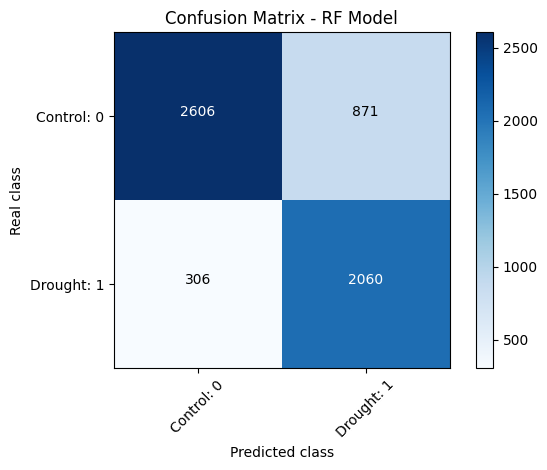

In [21]:
cnf_matrix = confusion_matrix(y_test, y_pred_rf)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix - RF Model',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #plt.ylim(0.5, 0.5)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(1.5, -0.5)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Real class')
    plt.xlabel('Predicted class')
    plt.tight_layout()

plot_confusion_matrix(cnf_matrix, classes=['Control: 0', 'Drought: 1'])

In [22]:
from sklearn.model_selection import train_test_split, cross_val_score
scores = cross_val_score(model_lgb, X_res, y_res, cv=4)
print("Scores:", scores)
print("Median:", scores.mean())

[LightGBM] [Info] Number of positive: 9023, number of negative: 12888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 21911, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.411802 -> initscore=-0.356520
[LightGBM] [Info] Start training from score -0.356520
[LightGBM] [Info] Number of positive: 9022, number of negative: 12889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 21911, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.411757 -> initscore=-0.356708
[LightGBM] [Info] Start training from score -0.356708
[LightGBM] [

In [23]:
from sklearn.model_selection import train_test_split, cross_val_score
scores = cross_val_score(modelrf, X_res, y_res, cv=4)
print("Scores:", scores)
print("Median:", scores.mean())

Scores: [0.72029025 0.8203724  0.81284228 0.7774887 ]
Median: 0.7827484080196904


In [24]:
import numpy as np
y_prob = model_lgb.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.0, 1.1, 0.1)
results = []

for threshold in thresholds:
    y_pred_test = (y_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    auc = roc_auc_score(y_test, y_prob)
    accuracy = accuracy_score(y_test, y_pred_test)

    results.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc,
        'Acurácia': accuracy
    })

results_df = pd.DataFrame(results)
print(results_df)

    Threshold  Precision  Recall  F1 Score  AUC  Acurácia
0        0.00       0.40    1.00      0.58 0.85      0.40
1        0.10       0.63    0.96      0.76 0.85      0.75
2        0.20       0.69    0.94      0.79 0.85      0.80
3        0.30       0.70    0.93      0.80 0.85      0.81
4        0.40       0.70    0.92      0.79 0.85      0.81
5        0.50       0.70    0.90      0.79 0.85      0.81
6        0.60       0.71    0.83      0.77 0.85      0.79
7        0.70       0.71    0.54      0.62 0.85      0.73
8        0.80       0.73    0.07      0.13 0.85      0.61
9        0.90       1.00    0.00      0.00 0.85      0.60
10       1.00       0.00    0.00      0.00 0.85      0.60


In [25]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
import numpy as np
y_prob = modelrf.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.0, 1.1, 0.1)
results = []

for threshold in thresholds:
    y_pred_test = (y_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    auc = roc_auc_score(y_test, y_prob)
    accuracy = accuracy_score(y_test, y_pred_test)

    results.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc,
        'Acurácia': accuracy
    })

results_df = pd.DataFrame(results)
print(results_df)

    Threshold  Precision  Recall  F1 Score  AUC  Acurácia
0        0.00       0.40    1.00      0.58 0.85      0.40
1        0.10       0.57    0.97      0.72 0.85      0.69
2        0.20       0.67    0.94      0.78 0.85      0.79
3        0.30       0.70    0.93      0.80 0.85      0.81
4        0.40       0.70    0.92      0.80 0.85      0.81
5        0.50       0.70    0.88      0.78 0.85      0.80
6        0.60       0.71    0.73      0.72 0.85      0.77
7        0.70       0.74    0.42      0.53 0.85      0.70
8        0.80       0.79    0.15      0.25 0.85      0.64
9        0.90       0.86    0.01      0.02 0.85      0.60
10       1.00       0.00    0.00      0.00 0.85      0.60
